<a href="https://colab.research.google.com/github/marhooo/AKMMH/blob/main/%D0%90%D0%9A%D0%9C%D0%9C%D0%9D_%D0%A4%D0%91_52%D0%BC%D0%BF_%D0%9F%D0%B5%D1%88%D0%BA%D0%BE%D0%B2%D0%B0_%D0%9C%D0%B0%D1%80%D0%B3%D0%B0%D1%80%D0%B8%D1%82%D0%B0_%D0%91%D0%BE%D0%BD%D0%B4%D0%B0%D1%80%D0%B5%D0%BD%D0%BA%D0%BE_%D0%AF%D0%BD%D0%B0_%D0%9F%D1%80_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Аналіз кіберінцидентів методами машинного навчання
Практична робота №6

Тема: Метод k-середніх, ієрархічна кластеризація в системах машинного навчання

**Метод К-середніх (K-Means)** — це один з найпопулярніших алгоритмів кластеризації (навчання без вчителя). Його мета — розділити набір даних на k (заздалегідь задану кількість) кластерів. Алгоритм ітеративно намагається мінімізувати суму квадратів відстаней між точками даних та центрами (центроїдами) їх кластерів.



Імпорт бібліотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
sns.set(style="whitegrid")
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import SimpleImputer
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score

Завантаження датасету та попередній перегляд даних

In [ ]:
file_path = 'synthetic_fraud_dataset.csv'
data = pd.read_csv(file_path)

print("Інформація про датасет:")
data.info()
print("\nПерші 5 рядків датасету:")
data.head()

Інформація про датасет:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14936 entries, 0 to 14935
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Transaction_ID                14936 non-null  object 
 1   User_ID                       14936 non-null  object 
 2   Transaction_Amount            14936 non-null  float64
 3   Transaction_Type              14936 non-null  object 
 4   Timestamp                     14936 non-null  object 
 5   Account_Balance               14936 non-null  float64
 6   Device_Type                   14936 non-null  object 
 7   Location                      14936 non-null  object 
 8   Merchant_Category             14936 non-null  object 
 9   IP_Address_Flag               14936 non-null  int64  
 10  Previous_Fraudulent_Activity  14936 non-null  int64  
 11  Daily_Transaction_Count       14936 non-null  int64  
 12  Avg_Transaction_Amount_7d     14936 

,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65.0,883.17,Biometric,0.8494,0.0,0.0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186.0,2203.36,Password,0.0959,0.0,1.0
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226.0,1909.29,Biometric,0.8400,0.0,1.0
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76.0,1311.86,OTP,0.7935,0.0,1.0
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140.0,966.98,Password,0.3819,1.0,1.0


## Підготовка та попередня обробка даних

Алгоритм K-Means працює лише з числовими даними і дуже чутливий до масштабу ознак (оскільки базується на відстанях). Тому необхідно виконати два ключові кроки:

1. Видалення непотрібних ознак- вдентифікаторів (Transaction_ID, User_ID) та часу (Timestamp), оскільки вони не допомагають у пошуку груп.

2. Видалення цільової змінної, бо  K-Means це навчання без вчителя. Необхідно видалити колонку Fraud_Label, оскільки це і є відповідь, яку, по суті, треба знайти опосередковано. Цю колонку буде збережено окремо, щоб пізніше порівняти з нашими кластерами.

3. Перетворення даних:

 - Категоріальні ознаки (Transaction_Type, Location тощо) перетворимо на числа за допомогою OneHotEncoder.

 - Числові ознаки (Transaction_Amount, Account_Balance) приведемо до єдиного масштабу за допомогою StandardScaler, щоб жодна ознака не домінувала над іншими.

Буде використано Pipeline та ColumnTransformer, щоб виконати ці кроки чисто та ефективно.

In [ ]:
# 1. Зберігаємо Fraud_Label для майбутнього аналізу
if 'Fraud_Label' in data.columns:
    fraud_labels_true = data['Fraud_Label']
    data_for_clustering = data.drop('Fraud_Label', axis=1)
else:
    data_for_clustering = data.copy()
    fraud_labels_true = None

# 2. Видаляємо інші непотрібні колонки
data_for_clustering = data_for_clustering.drop(['Transaction_ID', 'User_ID', 'Timestamp'], axis=1)

# 3. Визначаємо типи колонок
numeric_features = data_for_clustering.select_dtypes(include=np.number).columns
categorical_features = data_for_clustering.select_dtypes(include='object').columns

print(f"Числові ознаки ({len(numeric_features)}): {list(numeric_features)}")
print(f"Категоріальні ознаки ({len(categorical_features)}): {list(categorical_features)}")

# Створюємо пайплайн для обробки числових даних
# Додаємо SimpleImputer(strategy='median') перед StandardScaler
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Заповнюємо пропуски медіаною
    ('scaler', StandardScaler())
])

# Створюємо пайплайн для обробки категоріальних даних
# Додаємо SimpleImputer(strategy='most_frequent') перед OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Заповнюємо пропуски найчастішим значенням
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Об'єднуємо пайплайни за допомогою ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

# Застосовуємо препроцесор до даних
processed_data = preprocessor.fit_transform(data_for_clustering)

print(f"\nРозмірність даних після обробки: {processed_data.shape}")
print("Дані успішно підготовлено до кластеризації (з імп'ютером).")

Числові ознаки (11): ['Transaction_Amount', 'Account_Balance', 'IP_Address_Flag', 'Previous_Fraudulent_Activity', 'Daily_Transaction_Count', 'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Age', 'Transaction_Distance', 'Risk_Score', 'Is_Weekend']
Категоріальні ознаки (6): ['Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category', 'Card_Type', 'Authentication_Method']

Розмірність даних після обробки: (14936, 36)
Дані успішно підготовлено до кластеризації (з імп'ютером).


## Визначення оптимальної кількості кластерів (k)

Для знаходження оптимальної кількості кластерів k було застосовано два методи:
1. Метод ліктя (Elbow Method): Аналіз графіка суми квадратів відстаней (SSE) показав помітний "злам" (лікоть) при k=4 та k=5, що вказує на те, що подальше збільшення k дає менший приріст у якості.
2. Метод силуету (Silhouette Score): Цей метод дав більш чіткий результат. Найвищий коефіцієнт силуету (що свідчить про найкращу щільність і розділеність кластерів) спостерігався при k=2.

Враховуючи, що дані про шахрайство за своєю природою мають два основні стани ("шахрайство" та "не шахрайство"), і метод силуету чітко вказав на k=2, для роботи було обрано k=2 як оптимальну кількість кластерів для подальшого аналізу.

Розмір вибірки для розрахунку метрик: 10000
Розмір вибірки для Silhouette Score: 5000

Графік 'Метод ліктя' збережено у 'kmeans_elbow_plot.png'
Графік 'Метод силуету' збережено у 'kmeans_silhouette_plot.png'


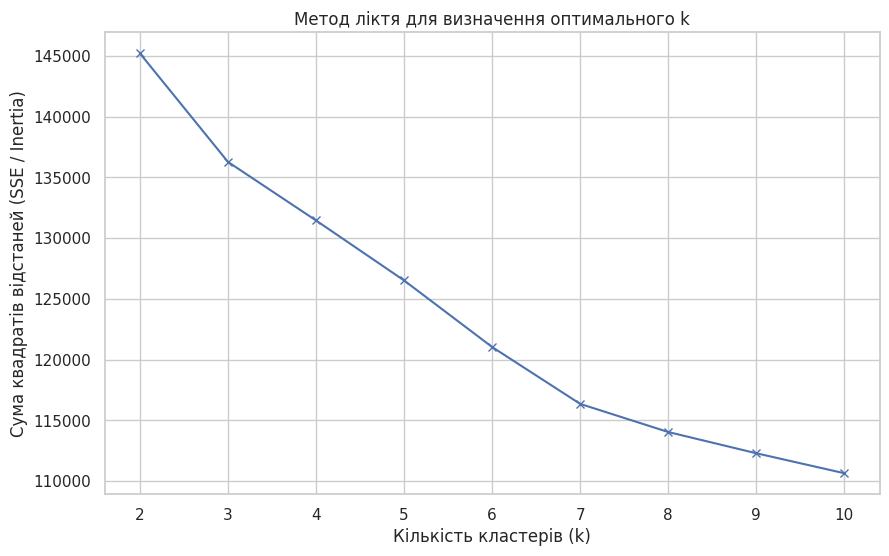

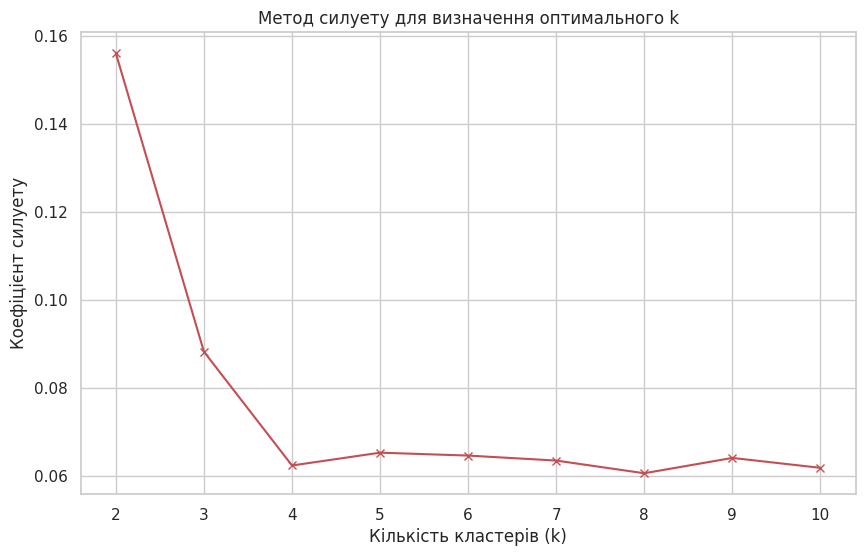

In [ ]:
# Через великий розмір датасету, було взято випадкову вибірку з даних для розрахунку метрик.
if processed_data.shape[0] > 10000:
    np.random.seed(42)
    sample_indices = np.random.choice(processed_data.shape[0], 10000, replace=False)
    data_sample_for_metrics = processed_data[sample_indices, :]
else:
    data_sample_for_metrics = processed_data

print(f"Розмір вибірки для розрахунку метрик: {data_sample_for_metrics.shape[0]}")


# 1. Метод ліктя (Elbow Method)
sse = {}
k_range = range(2, 11) # Тестуємо k від 2 до 10

for k in k_range:
    #print(f"Розрахунок для k={k}...")
    # n_init=10 для стабільності, random_state для відтворюваності
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42, max_iter=200)

    kmeans.fit(data_sample_for_metrics)
    sse[k] = kmeans.inertia_

# 2. Метод силуету (Silhouette Score)
silhouette_scores = {}
# Візьмемо ще меншу вибірку для силуету, щоб прискорити
if data_sample_for_metrics.shape[0] > 5000:
    np.random.seed(42)
    sample_indices_silhouette = np.random.choice(data_sample_for_metrics.shape[0], 5000, replace=False)
    data_sample_for_silhouette = data_sample_for_metrics[sample_indices_silhouette, :]
else:
    data_sample_for_silhouette = data_sample_for_metrics

print(f"Розмір вибірки для Silhouette Score: {data_sample_for_silhouette.shape[0]}")

for k in k_range: # k=1 не має сенсу для силуету
    #print(f"Розрахунок Silhouette для k={k}...")
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42, max_iter=200)

    # Навчання на одній вибірці
    kmeans.fit(data_sample_for_metrics)
    # Передбачення кластерів
    labels = kmeans.predict(data_sample_for_silhouette)
    # Розрахунок силуету на іншій (меншій)
    silhouette_scores[k] = silhouette_score(data_sample_for_silhouette, labels)


# 3. Візуалізація результатів

# Графік "Метод ліктя"
plt.figure(figsize=(10, 6))
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel('Кількість кластерів (k)')
plt.ylabel('Сума квадратів відстаней (SSE / Inertia)')
plt.title('Метод ліктя для визначення оптимального k')
plt.xticks(list(k_range))
plt.grid(True)
plt.savefig('kmeans_elbow_plot.png')
print("\nГрафік 'Метод ліктя' збережено у 'kmeans_elbow_plot.png'")

# Графік "Метод силуету"
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 'rx-')
plt.xlabel('Кількість кластерів (k)')
plt.ylabel('Коефіцієнт силуету')
plt.title('Метод силуету для визначення оптимального k')
plt.xticks(list(k_range))
plt.grid(True)
plt.savefig('kmeans_silhouette_plot.png')
print("Графік 'Метод силуету' збережено у 'kmeans_silhouette_plot.png'")

## Застосування K-Means та аналіз результатів
Тепер, коли визначено оптимальну кількість кластерів (k=2), буде застосовано алгоритм K-Means до всього обробленого набору даних (processed_data).Після цього буде додано отримані мітки кластерів до початкового, необробленого датасету (разом із Fraud_Label, яку було збережено на початку), що дозволить  проаналізувати, як K-Means згрупував дані та чи відповідають ці групи реальним випадкам шахрайства.

Застосовуємо K-Means з k=2 до повного набору даних...
Модель навчено, кластери призначено.

Початкові дані з доданими мітками кластерів:
  Transaction_ID    User_ID  Transaction_Amount Transaction_Type  \
0      TXN_33553  USER_1834               39.79              POS   
1       TXN_9427  USER_7875                1.19    Bank Transfer   
2        TXN_199  USER_2734               28.96           Online   
3      TXN_12447  USER_2617              254.32   ATM Withdrawal   
4      TXN_39489  USER_2014               31.28              POS   

             Timestamp  Account_Balance Device_Type  Location  \
0  2023-08-14 19:30:00         93213.17      Laptop    Sydney   
1  2023-06-07 04:01:00         75725.25      Mobile  New York   
2  2023-06-20 15:25:00          1588.96      Tablet    Mumbai   
3  2023-12-07 00:31:00         76807.20      Tablet  New York   
4  2023-11-11 23:44:00         92354.66      Mobile    Mumbai   

  Merchant_Category  IP_Address_Flag  ...  Avg_Transaction_Amou

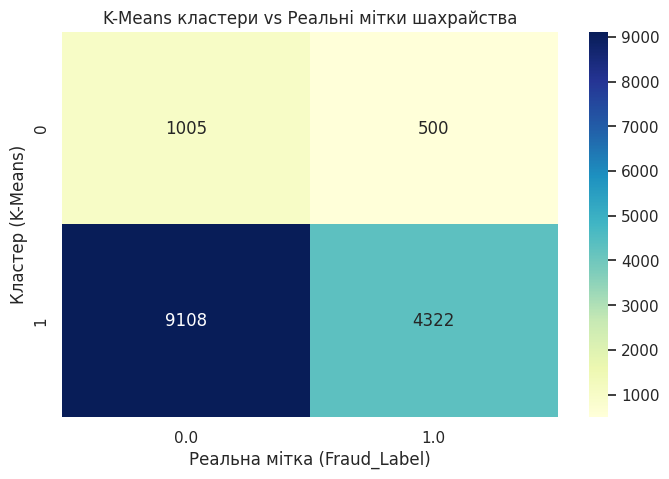

In [ ]:
# Оптимальне k
OPTIMAL_K = 2

# Створення та навчання моделі K-Means
print(f"Застосовуємо K-Means з k={OPTIMAL_K} до повного набору даних...")
kmeans_final = KMeans(n_clusters=OPTIMAL_K, n_init=10, random_state=42)

# Навчання моделі на повних оброблених даних
kmeans_final.fit(processed_data)
cluster_labels = kmeans_final.labels_

print("Модель навчено, кластери призначено.")

# Аналіз результатів
# Додамо мітки кластерів до початкового датасету для інтерпретації
results_df = data.copy()
results_df['Cluster_KMeans'] = cluster_labels

print("\nПочаткові дані з доданими мітками кластерів:")
print(results_df.head())

# Порівняння кластерів з реальними мітками шахрайства
if 'Fraud_Label' in results_df.columns:
    print("\nПорівняння результатів кластеризації з реальними мітками 'Fraud_Label':")

    # Використання pd.crosstab() для створення матриці спряженості (contingency table)
    # Це покаже, скільки шахрайських/нешахрайських транзакцій потрапило в який кластер
    contingency_table = pd.crosstab(results_df['Cluster_KMeans'], results_df['Fraud_Label'])

    print("Матриця спряженості (Cluster vs Fraud_Label):")
    print(contingency_table)

    plt.figure(figsize=(8, 5))
    sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu')
    plt.title('K-Means кластери vs Реальні мітки шахрайства')
    plt.xlabel('Реальна мітка (Fraud_Label)')
    plt.ylabel('Кластер (K-Means)')
    plt.show()

else:
    print("\nКолонка 'Fraud_Label' не знайдена для порівняння.")

Після застосування K-Means з $k=2$ ми порівняли отримані кластери з реальними мітками шахрайства (Fraud_Label). Матриця спряженості дала ключовий результат:

Fraud_Label      0.0   1.0

Cluster_KMeans            
0 1005   500   (Приблизно 33.2% шахрайства)


1               9108  4322   (Приблизно 32.2% шахрайства)

Аналіз показує, що хоча метод силуету вказав на $k=2$, алгоритм K-Means не зміг ізолювати шахрайські транзакції. Відсоток шахрайства в обох кластерах практично однаковий, що свідчить про те, що поділ відбувся за якимись іншими, більш вираженими ознаками (наприклад, Transaction_Type, Location або Transaction_Amount), а не за ознаками, унікальними для шахрайства.

Це було так, оскільки K-Means шукає "великі" групи, мета K-Means - мінімізувати відстань до центрів кластерів. Він чудово знаходить великі, щільні, "сферичні" групи даних.
Шахрайство - це аномалія, а не кластер: у нашому датасеті шахрайські транзакції (Fraud_Label = 1), ймовірно, не утворюють окремий, щільний кластер. Натомість, вони є аномаліями - точками, які "розкидані" всередині великих груп легітимних транзакцій (наприклад, шахрайська "Online" транзакція виглядає дуже схожою на звичайну "Online" транзакцію за багатьма параметрами).
Отже, K-Means успішно знайшов якусь домінуючу структуру в даних (розділивши їх на дві групи), але ця структура не мала нічого спільного з шахрайством.

Загальний висновок по K-Means: Метод K-середніх у його стандартній реалізації виявився неефективним для задачі виявлення шахрайства на цьому наборі даних, оскільки логіка його роботи (пошук великих центрів мас) не відповідає природі проблеми (пошук рідкісних аномалій).

**Ієрархічна кластеризація (Агломеративна)**
Метод Ієрархічної кластеризації — це підхід до навчання без вчителя, який будує ієрархію кластерів. Надалі буде використано агломеративний (bottom-up) метод, де кожна точка починає як свій кластер, а потім найближчі кластери послідовно об'єднуються, доки не залишиться один загальний кластер. Результатом є дендрограма, що являє собою деревоподібну структура, яка візуалізує цей процес.

**Побудова дендрограми**
Ієрархічна кластеризація є обчислювально складною. Застосувати її до повного набору даних у 50 000 точок неможливо (це займе велику кількість часу). Тому, щоб візуалізувати структуру даних, ми візьмемо репрезентативну випадкову вибірку у 1000 точок з нашого обробленого набору даних (processed_data).

Ми побудуємо дендрограму, використовуючи метод Уорда (Ward). Цей метод мінімізує дисперсію всередині кластерів, що об'єднуються. Дендрограма допоможе нам візуально обрати оптимальну кількість кластерів (k) для цього методу.

Розмір вибірки для дендрограми: 1000 точок
Розрахунок дендрограми... (Це може зайняти деякий час)
Дендрограму збережено у 'hierarchical_dendrogram.png'


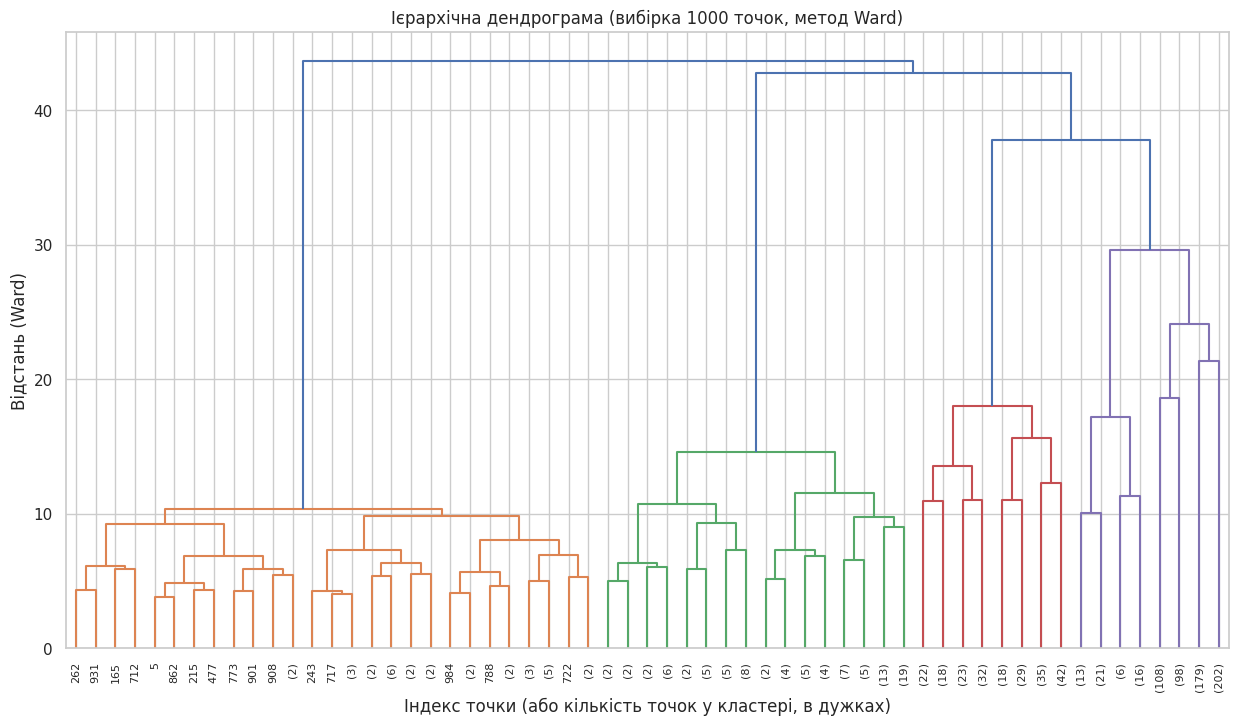

In [ ]:
# 'processed_data' - наш повний оброблений набір (50000 точок)
# 'fraud_labels_true' - збережені реальні мітки (з Кроку 2)

# 1. Створюємо вибірку (sample) для дендрограми
np.random.seed(42)
sample_size = 1000

if processed_data.shape[0] > sample_size:
    sample_indices = np.random.choice(processed_data.shape[0], sample_size, replace=False)
    data_sample_for_dendrogram = processed_data[sample_indices, :]

    # Також збережемо відповідні реальні мітки для цієї вибірки
    if fraud_labels_true is not None:
        # Використовуємо .iloc для індексації pandas Series
        labels_sample_true = fraud_labels_true.iloc[sample_indices].reset_index(drop=True)
    else:
        labels_sample_true = None

else:
    data_sample_for_dendrogram = processed_data
    labels_sample_true = fraud_labels_true # .reset_index(drop=True) не потрібен, якщо беремо все

print(f"Розмір вибірки для дендрограми: {data_sample_for_dendrogram.shape[0]} точок")

# 2. Побудова дендрограми

plt.figure(figsize=(15, 8))
plt.title(f'Ієрархічна дендрограма (вибірка {sample_size} точок, метод Ward)')

# Розрахунок матриці зв'язків
Z = sch.linkage(data_sample_for_dendrogram, method='ward')

# Візуалізація дендрограми
# p=5 - покажемо лише 5 верхніх рівнів ієрархії, щоб графік був читабельним
# truncate_mode='level' - обрізаємо за рівнем
dendrogram = sch.dendrogram(
    Z,
    truncate_mode='level',
    p=5,
    leaf_rotation=90.,
    leaf_font_size=8.
)

plt.xlabel('Індекс точки (або кількість точок у кластері, в дужках)')
plt.ylabel('Відстань (Ward)')
plt.savefig('hierarchical_dendrogram.png')

**Аналіз ієрархічної структури даних**

Для візуального дослідження структури даних та ієрархії кластерів було побудовано дендрограму. З огляду на великий обсяг повного набору (50 000 спостережень), для візуалізації було використано репрезентативну випадкову вибірку розміром 1000 точок.

Дендрограму було згенеровано з використанням методу Уорда (Ward's method), який мінімізує загальну дисперсію всередині кластерів під час їх об'єднання. На графіку вертикальна вісь (Y) представляє відстань Уорда - міру "вартості" об'єднання двох кластерів; вищі значення на цій осі відповідають об'єднанню більш різнорідних (віддалених) груп.

Для покращення читабельності графік було обрізано (truncate_mode='level', p=5), щоб відобразити лише 5 верхніх рівнів ієрархії. Це дозволяє зосередитись на найважливіших, високорівневих поділах у даних, а не на окремих точках.

Аналіз дендрограми дозволяє візуально ідентифікувати "природну" кількість кластерів. Найдовші вертикальні лінії на графіку вказують на найбільші "стрибки" відстані, необхідні для об'єднання груп. Перетин графіка горизонтальною лінією на рівні цих довгих "стовбурів" дає змогу оцінити оптимальну кількість кластерів, оскільки ці групи є найбільш відмінними одна від одної. Числа в дужках ( ) на горизонтальній осі (X) вказують на кількість точок вибірки, що входять до кожного з кінцевих "листя" обрізаного дерева.

**Практичний аналіз дендрограми**

Аналіз ієрархічної дендрограми (вибірка 1000 точок, метод Уорда) виявляє чітку, асиметричну кластерну структуру, що є типовою для завдань виявлення аномалій або шахрайства.

1. Головний поділ (k=2): Найважливіший практичний висновок ґрунтується на найвищому об'єднанні на графіку. На рівні Відстані Уорда ≈ 43 (найвища синя "перекладина") вся вибірка розділяється на два фундаментально різні кластери:

Кластер 1 (Ліва група): Це значно менший кластер, що складається з груп, позначених помаранчевим та зеленим кольором. Він об'єднує сукупність дрібних груп та окремих точок.

Кластер 2 (Права група): Це домінуючий, масивний кластер, що об'єднує переважну більшість точок (групи, позначені червоним та фіолетовим). Судячи з чисел в дужках (напр., (202), (179), (135) та ін.), цей кластер вміщує ~90-95% вибірки.

Така чітка асиметрія є класичним сценарієм виявлення аномалій. Права, велика група (червона + фіолетова), найімовірніше, представляє "нормальні" спостереження. Ліва, мала група (помаранчева + зелена), яка настільки сильно відрізняється від норми, що приєднується до неї лише на дуже високій відстані (Y ≈ 43), з високою ймовірністю представляє аномалії або викиди (потенційно — шахрайські транзакції).

2. Вторинний поділ (k=3): Графік також чітко показує поділ всередині "нормального" кластера. Наступний за значущістю поділ відбувається на Відстані ≈ 38, де "права" група ділиться на:

Червоний кластер (середній за розміром, ~224 точки)

Фіолетовий кластер (найбільший, ~692 точки)

 Це говорить про те, що "нормальна" поведінка у даних також є неоднорідною. Вона складається з двох різних підтипів, які також суттєво відрізняються один від одного.

Таким чином, дендрограма чітко показує, що дані мають природну схильність до поділу на k=2 (Норма vs. Аномалії) або k=3 (Норма_типу_А, Норма_типу_Б та Аномалії). Обидва варіанти є обґрунтованими, але поділ на два кластери є найбільш фундаментальним і статистично значущим для обраного набору даних.

In [ ]:
# Фінальне порівняння K-Means (k=2 vs k=3)
print(" Фінальне порівняння K-Means (k=2 vs k=3) ")

# --- Модель K-Means з k=2 ---
print("\n--- Запуск K-Means з k=2 ---")
kmeans_k2 = KMeans(n_clusters=2, random_state=42, n_init=10)
labels_k2 = kmeans_k2.fit_predict(processed_data)

print("\n--- Оцінка K-Means (k=2) ---")
if fraud_labels_true is not None:
    # Створюємо "маску" для відбору лише тих рядків, де реальна мітка НЕ є NaN
    valid_indices_mask = fraud_labels_true.notna()

    # Фільтруємо обидва масиви за цією маскою
    labels_true_filtered = fraud_labels_true[valid_indices_mask]
    labels_k2_filtered = labels_k2[valid_indices_mask]

    ars_k2 = adjusted_rand_score(labels_true_filtered, labels_k2_filtered)
    hs_k2 = homogeneity_score(labels_true_filtered, labels_k2_filtered)
    cs_k2 = completeness_score(labels_true_filtered, labels_k2_filtered)

    print(f"Adjusted Rand Score (k=2): {ars_k2:.4f}")
    print(f"Homogeneity Score (k=2): {hs_k2:.4f}")
    print(f"Completeness Score (k=2): {cs_k2:.4f}")

    print("\nТаблиця відповідності (k=2):")
    contingency_matrix_k2 = pd.crosstab(labels_k2_filtered, labels_true_filtered)
    contingency_matrix_k2.index.name = 'K-Means Cluster'
    contingency_matrix_k2.columns.name = 'Real Fraud Label'
    print(contingency_matrix_k2)
else:
    print("Реальні мітки ('fraud_labels_true') недоступні для порівняння.")

print("\nРозрахунок Silhouette Score (на вибірці 1000 точок)...")
labels_k2_sample = labels_k2[sample_indices]
silhouette_avg_k2 = silhouette_score(data_sample_for_dendrogram, labels_k2_sample)
print(f"Silhouette Score (k=2, на вибірці): {silhouette_avg_k2:.4f}")

# --- Модель K-Means з k=3 ---
print("\n--- Запуск K-Means з k=3 (з аналізу дендрограми) ---")
kmeans_k3 = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_k3 = kmeans_k3.fit_predict(processed_data)

print("\n--- Оцінка K-Means (k=3) ---")
if fraud_labels_true is not None:
    # Використовуємо ту саму маску valid_indices_mask
    labels_k3_filtered = labels_k3[valid_indices_mask]
    # labels_true_filtered вже є з попереднього кроку

    ars_k3 = adjusted_rand_score(labels_true_filtered, labels_k3_filtered)
    hs_k3 = homogeneity_score(labels_true_filtered, labels_k3_filtered)
    cs_k3 = completeness_score(labels_true_filtered, labels_k3_filtered)

    print(f"Adjusted Rand Score (k=3): {ars_k3:.4f}")
    print(f"Homogeneity Score (k=3): {hs_k3:.4f}")
    print(f"Completeness Score (k=3): {cs_k3:.4f}")

    print("\nТаблиця відповідності (k=3):")
    contingency_matrix_k3 = pd.crosstab(labels_k3_filtered, labels_true_filtered)
    contingency_matrix_k3.index.name = 'K-Means Cluster'
    contingency_matrix_k3.columns.name = 'Real Fraud Label'
    print(contingency_matrix_k3)
else:
    print("Реальні мітки ('fraud_labels_true') недоступні для порівняння.")

print("\nРозрахунок Silhouette Score (на вибірці 1000 точок)...")
labels_k3_sample = labels_k3[sample_indices]
silhouette_avg_k3 = silhouette_score(data_sample_for_dendrogram, labels_k3_sample)
print(f"Silhouette Score (k=3, на вибірці): {silhouette_avg_k3:.4f}")

print("\n--- ЗАГАЛЬНИЙ ПІДСУМОК ПОРІВНЯННЯ ---")
print(f"Silhouette (k=2): {silhouette_avg_k2:.4f}")
print(f"Silhouette (k=3): {silhouette_avg_k3:.4f}")
if fraud_labels_true is not None:
    print(f"Adjusted Rand Score (k=2): {ars_k2:.4f}")
    print(f"Adjusted Rand Score (k=3): {ars_k3:.4f}")

print("\nПорівняння завершено.")

 Фінальне порівняння K-Means (k=2 vs k=3) 

--- Запуск K-Means з k=2 ---

--- Оцінка K-Means (k=2) ---
Adjusted Rand Score (k=2): 0.0023
Homogeneity Score (k=2): 0.0000
Completeness Score (k=2): 0.0001

Таблиця відповідності (k=2):
Real Fraud Label   0.0   1.0
K-Means Cluster             
0                 1005   500
1                 9108  4322

Розрахунок Silhouette Score (на вибірці 1000 точок)...
Silhouette Score (k=2, на вибірці): 0.1548

--- Запуск K-Means з k=3 (з аналізу дендрограми) ---

--- Оцінка K-Means (k=3) ---
Adjusted Rand Score (k=3): 0.0020
Homogeneity Score (k=3): 0.0000
Completeness Score (k=3): 0.0000

Таблиця відповідності (k=3):
Real Fraud Label   0.0   1.0
K-Means Cluster             
0                 2688  1294
1                 6420  3028
2                 1005   500

Розрахунок Silhouette Score (на вибірці 1000 точок)...
Silhouette Score (k=3, на вибірці): 0.0896

--- ЗАГАЛЬНИЙ ПІДСУМОК ПОРІВНЯННЯ ---
Silhouette (k=2): 0.1548
Silhouette (k=3): 0.0896
Adjuste

Теплові карти збережено у 'kmeans_heatmaps_comparison.png'

Розрахунок PCA для візуалізації...
Створено вибірку 5000 точок для PCA-графіка.
PCA-графіки збережено у 'kmeans_pca_comparison.png'


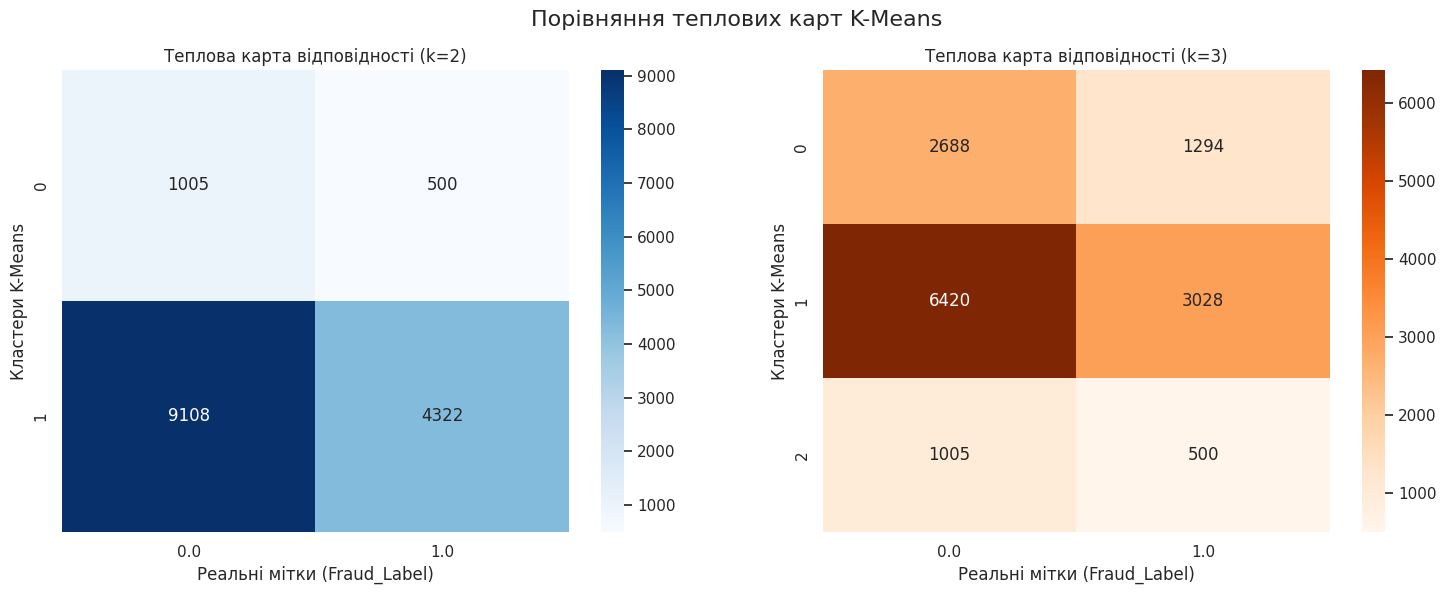

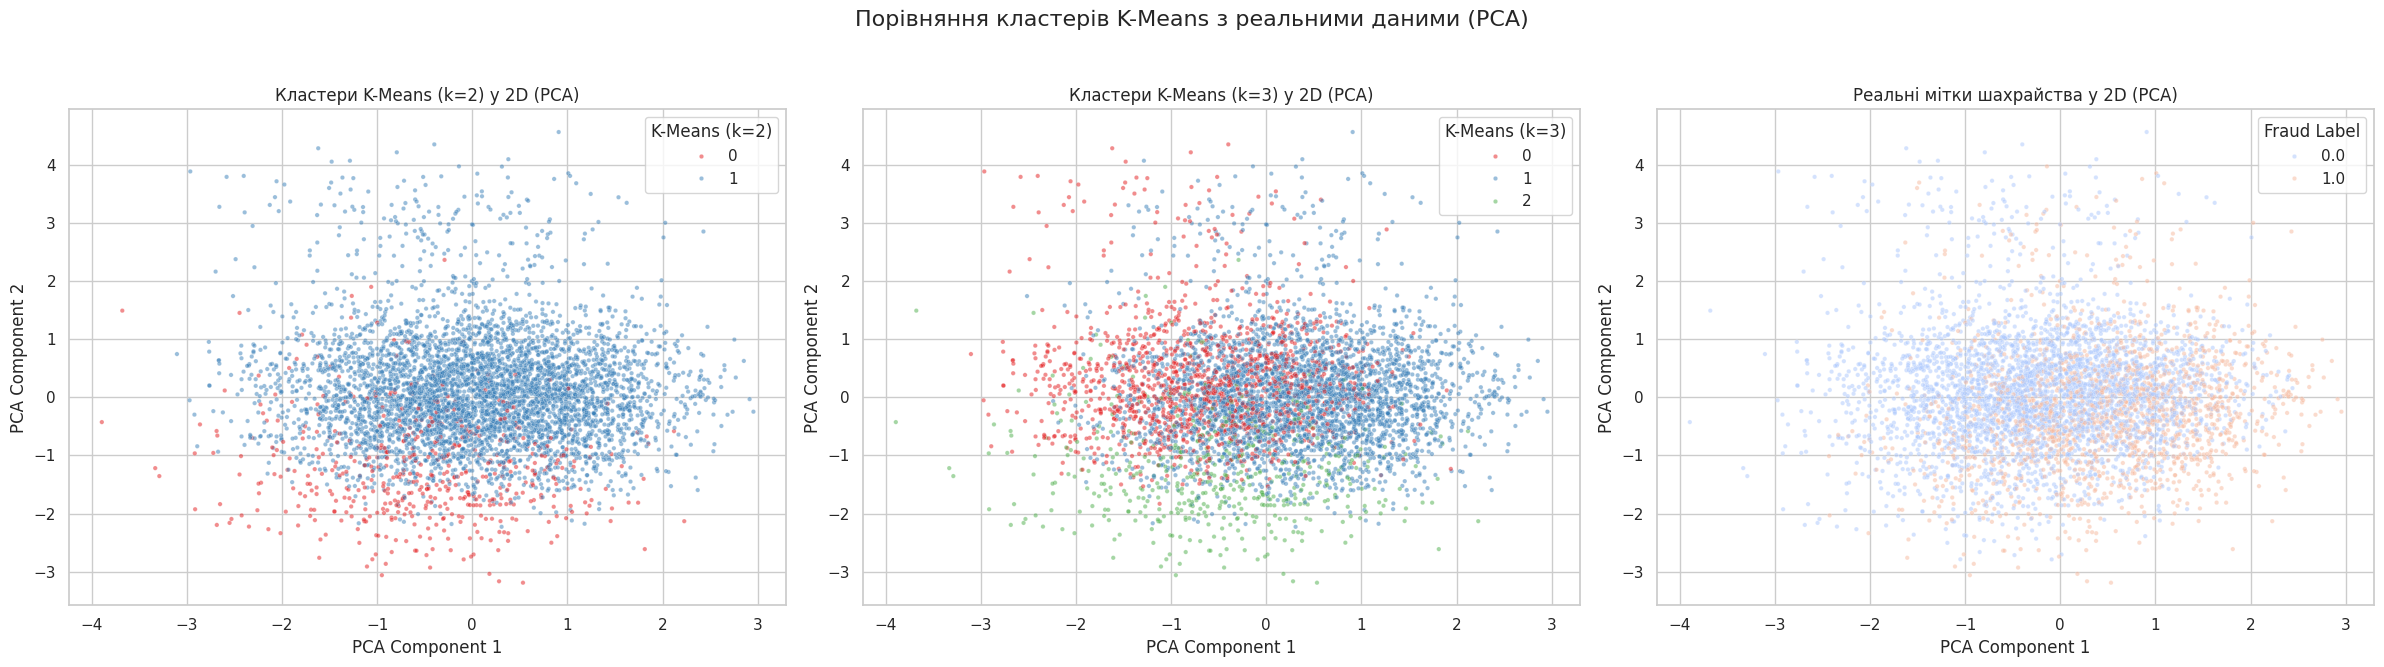

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

# --- 1. Візуалізація: Теплові карти відповідності ---
# Це візуальне представлення таблиць, які ви вже отримали

plt.figure(figsize=(18, 6))

# Теплова карта для k=2
plt.subplot(1, 2, 1)
sns.heatmap(contingency_matrix_k2, annot=True, fmt='d', cmap='Blues')
plt.title('Теплова карта відповідності (k=2)')
plt.xlabel('Реальні мітки (Fraud_Label)')
plt.ylabel('Кластери K-Means')

# Теплова карта для k=3
plt.subplot(1, 2, 2)
sns.heatmap(contingency_matrix_k3, annot=True, fmt='d', cmap='Oranges')
plt.title('Теплова карта відповідності (k=3)')
plt.xlabel('Реальні мітки (Fraud_Label)')
plt.ylabel('Кластери K-Means')

plt.suptitle('Порівняння теплових карт K-Means', fontsize=16)
plt.savefig('kmeans_heatmaps_comparison.png')
print("Теплові карти збережено у 'kmeans_heatmaps_comparison.png'")
# plt.show()


# --- 2. Візуалізація: Зниження розмірності (PCA) ---
# Ми не можемо візуалізувати 20+ вимірів.
# Стиснемо дані до 2D (PCA) і подивимося, де знаходяться кластери.

print("\nРозрахунок PCA для візуалізації...")
pca = PCA(n_components=2)
processed_data_2d = pca.fit_transform(processed_data)

# Створюємо DataFrame для зручності
pca_df = pd.DataFrame(
    data=processed_data_2d,
    columns=['PCA Component 1', 'PCA Component 2']
)

# Додаємо мітки кластерів та реальні мітки (лише валідні)
pca_df['Cluster_K2'] = labels_k2
pca_df['Cluster_K3'] = labels_k3
# Додаємо відфільтровані реальні мітки
# Важливо: використовуємо .loc[valid_indices_mask], щоб індекси збігалися
pca_df['Real_Fraud'] = fraud_labels_true[valid_indices_mask]

# Через 50,000 точок, графік буде "чорним".
# Беремо випадкову вибірку з 5000 точок ТІЛЬКИ для візуалізації
pca_df_sample = pca_df.sample(n=5000, random_state=42)
print("Створено вибірку 5000 точок для PCA-графіка.")


# --- Побудова графіків PCA ---
plt.figure(figsize=(24, 7))

# Графік 1: Колір за кластером K-Means (k=2)
plt.subplot(1, 3, 1)
sns.scatterplot(
    data=pca_df_sample,
    x='PCA Component 1', y='PCA Component 2',
    hue='Cluster_K2',
    palette='Set1',
    alpha=0.5, s=10
)
plt.title('Кластери K-Means (k=2) у 2D (PCA)')
plt.legend(title='K-Means (k=2)')

# Графік 2: Колір за кластером K-Means (k=3)
plt.subplot(1, 3, 2)
sns.scatterplot(
    data=pca_df_sample,
    x='PCA Component 1', y='PCA Component 2',
    hue='Cluster_K3',
    palette='Set1',
    alpha=0.5, s=10
)
plt.title('Кластери K-Means (k=3) у 2D (PCA)')
plt.legend(title='K-Means (k=3)')

# Графік 3: Колір за РЕАЛЬНИМИ мітками (Ground Truth)
plt.subplot(1, 3, 3)
sns.scatterplot(
    # Використовуємо .dropna(), щоб прибрати NaN з Real_Fraud (які ми відфільтрували раніше)
    data=pca_df_sample.dropna(subset=['Real_Fraud']),
    x='PCA Component 1', y='PCA Component 2',
    hue='Real_Fraud',
    palette='coolwarm',
    alpha=0.5, s=10
)
plt.title('Реальні мітки шахрайства у 2D (PCA)')
plt.legend(title='Fraud Label')

plt.suptitle('Порівняння кластерів K-Means з реальними даними (PCA)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('kmeans_pca_comparison.png')
print("PCA-графіки збережено у 'kmeans_pca_comparison.png'")
# plt.show()

У ході лабораторної роботи було реалізовано алгоритми кластеризації K-Means та ієрархічної кластеризації (метод Уорда) для набору даних фінансових транзакцій. Було досліджено залежність точності виявлення шахрайства від кількості кластерів (k).

Візуальний аналіз дендрограми показав, що дані мають природну схильність до поділу на 2 великі групи.При застосуванні алгоритму K-Means було протестовано параметри k=2 та k=3.Найкращий показник якості самого розбиття (Silhouette Score) було отримано для k=2 (0.1548), що підтверджує попередній аналіз.

Попри наявність чіткої кластерної структури, порівняння з реальними мітками (Fraud_Label) показало, що знайдені кластери не відповідають класам "Шахрайство" та "Норма".Adjusted Rand Score для k=2 становить лише 0.0023 (близько до 0, що означає випадковий збіг).Таблиці спряженості показали, що шахрайські транзакції розподілені пропорційно між усіма кластерами.

Експеримент довів, що для даного набору даних метод K-Means не є ефективним для прямого виявлення шахрайства. Геометрична структура даних така, що шахрайські операції не утворюють окремого, віддаленого кластера в евклідовому просторі ознак, а "маскуються" серед легітимних транзакцій. Для ефективної детектиції рекомендується використовувати методи навчання з вчителем (Supervised Learning) або спеціалізовані методи пошуку аномалій (наприклад, Isolation Forest).